# Compute data summary statistics
Now that we've organized and cleaned the question data, let's compute some statistics.

In [1]:
# load data
import pandas as pd
# data = pd.read_csv('../../data/reddit_data/combined_data_question_data.gz', sep='\t', compression='gzip')
comment_data = pd.read_csv('../../data/reddit_data/advice_subreddit_filter_comment_question_data.gz', sep='\t', compression='gzip')
post_data = pd.read_csv('../../data/reddit_data/subreddit_submissions_2018-01_2019-12.gz', sep='\t', compression='gzip', index_col=False, usecols=['id', 'selftext'])
post_data.rename(columns={'selftext' : 'article_text', 'id' : 'parent_id'}, inplace=True)
data = pd.merge(comment_data, post_data, on=['parent_id'], how='left')
print(f'{data.shape[0]} total questions')
print(f'{data.loc[:, "parent_id"].nunique()} total posts')

730620 total questions
270694 total posts


## Text statistics

In [2]:
from tqdm import tqdm
tqdm.pandas()
from nltk.tokenize import WordPunctTokenizer
word_tokenizer = WordPunctTokenizer()
data = data.assign(**{
    'post_tokens' : data.loc[:, 'article_text'].progress_apply(lambda x: word_tokenizer.tokenize(x)),
    'question_tokens' : data.loc[:, 'question'].progress_apply(lambda x: word_tokenizer.tokenize(x)),
})

100%|██████████| 730620/730620 [00:19<00:00, 38435.29it/s] 


In [3]:
import numpy as np
post_len = data.loc[:, "post_tokens"].apply(lambda x: len(x)).values
question_len = data.loc[:, "question_tokens"].apply(lambda x: len(x)).values
print(f'mean post length = {np.mean(post_len)} +/- {np.std(post_len)}')
print(f'mean question length = {np.mean(question_len)} +/- {np.std(question_len)}')

mean post length = 304.33780487804876 +/- 220.58549234310797
mean question length = 13.888070405956585 +/- 8.079854409405339


## Author data
What % of the data includes metadata about authors?

In [4]:
author_data = pd.read_csv('../../data/reddit_data/author_data/combined_author_prior_comment_data.gz', sep='\t', compression='gzip')
# fix date var
from datetime import datetime
author_data = author_data.assign(**{'date_day_bin' : pd.Series(author_data.loc[:, 'date_day_bin'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d')).values, dtype='object')})
# author_data = author_data.assign(**{'date_day_bin' : author_data.loc[:, 'date_day_bin'].apply(lambda x: x.to_pydatetime()).values})
display(author_data.head())

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (1,2,8,9,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,author,date_day,subreddit,expert_pct,relative_time,expert_pct_bin,relative_time_bin,age,location_self_id,location,location_region,subreddit_country,date_day_bin,text_embed,subreddit_embed
0,talosguideu,2019-06-05,Advice,0.010000,6.247118,0.0,0.0,-1.0,us,us,US,UNK,2019-01-01 00:00:00,"[0.22358277440071106, 0.28246960043907166, -0....","[16.383529609746823, 11.534988324393423, 4.245..."
1,talosguideu,2019-03-02,Advice,0.010101,6.265348,0.0,0.0,-1.0,us,us,US,UNK,2019-01-01 00:00:00,"[0.22358277440071106, 0.28246960043907166, -0....","[16.383529609746823, 11.534988324393423, 4.245..."
2,talosguideu,2019-03-30,Advice,0.010000,6.247118,0.0,0.0,-1.0,us,us,US,UNK,2019-01-01 00:00:00,"[0.22358277440071106, 0.28246960043907166, -0....","[16.383529609746823, 11.534988324393423, 4.245..."
3,talosguideu,2019-05-18,Advice,0.010000,6.247118,0.0,0.0,-1.0,us,us,US,UNK,2019-01-01 00:00:00,"[0.22358277440071106, 0.28246960043907166, -0....","[16.383529609746823, 11.534988324393423, 4.245..."
4,talosguideu,2019-05-24,Advice,0.010000,6.247118,0.0,0.0,-1.0,us,us,US,UNK,2019-01-01 00:00:00,"[0.22358277440071106, 0.28246960043907166, -0....","[16.383529609746823, 11.534988324393423, 4.245..."


In [5]:
valid_authors = set(author_data.loc[:, 'author'].unique())
valid_author_data = data[data.loc[:, 'author'].isin(valid_authors)]
print(f'{valid_author_data.shape[0]/data.shape[0]*100}% questions can be connected to an author with some kind of data')

65.36338999753633% questions can be connected to an author with some kind of data


Any difference for discrete and continuous representation?

In [6]:
discrete_vars = ['expert_pct_bin', 'location']
continuous_vars = ['text_embed', 'subreddit_embed']
valid_discrete_var_authors = set(author_data.dropna(subset=discrete_vars, how='all').loc[:, 'author'].unique())
valid_continuous_var_authors = set(author_data.dropna(subset=continuous_vars, how='all').loc[:, 'author'].unique())
discrete_var_author_data = data[data.loc[:, 'author'].isin(valid_discrete_var_authors)]
continuous_var_author_data = data[data.loc[:, 'author'].isin(valid_continuous_var_authors)]
print(f'{discrete_var_author_data.shape[0]/data.shape[0]*100}% questions can be connected to an author with a discrete representation')
print(f'{continuous_var_author_data.shape[0]/data.shape[0]*100}% questions can be connected to an author with a continuous representation')

62.91191043223564% questions can be connected to an author with a discrete representation
50.71035558840437% questions can be connected to an author with a continuous representation


### Subreddit stats
What is the distribution of posts/questions in each subreddit?

Let's make this into a nice bar plot.

In [7]:
per_subreddit_post_counts = data.drop_duplicates('parent_id').loc[:, 'subreddit'].value_counts().reset_index(name='Count').rename(columns={'index' : 'Subreddit'})
per_subreddit_question_counts = data.loc[:, 'subreddit'].value_counts().reset_index(name='Count').rename(columns={'index' : 'Subreddit'})
per_subreddit_post_counts = per_subreddit_post_counts.assign(**{'Data Type' : 'post'})
per_subreddit_question_counts = per_subreddit_question_counts.assign(**{'Data Type' : 'question'})
per_subreddit_counts = pd.concat([per_subreddit_post_counts, per_subreddit_question_counts], axis=0)

In [10]:
display(pd.pivot(per_subreddit_counts, index='Subreddit', columns=['Data Type'], values='Count'))

Data Type,post,question
Subreddit,,
Advice,48858,87592
AmItheAsshole,61857,331345
legaladvice,53577,92737
pcmasterrace,31657,47613
personalfinance,74745,171333


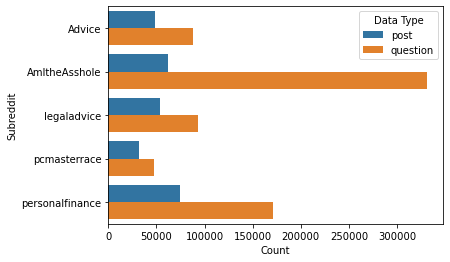

In [9]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
ordered_subreddits = list(sorted(per_subreddit_counts.loc[:, 'Subreddit'].unique()))
sns.barplot(data=per_subreddit_counts, y='Subreddit', x='Count', hue='Data Type', order=ordered_subreddits)
plt.show()

## Text+author data
What is the representation of authors in the text data?

We want % of comments with each reader group and embedding type.

In [10]:
# ## get author+text data from cleaned generation data
import torch
train_data = torch.load('../../data/reddit_data/combined_data_train_data.pt')
test_data = torch.load('../../data/reddit_data/combined_data_val_data.pt')
# convert to dataframe because it's easier to combine
train_data_df = train_data.data.to_pandas()
test_data_df = test_data.data.to_pandas()
import pandas as pd
author_vars = ['reader_token_str', 'author_has_subreddit_embed', 'author_has_text_embed', 'article_id']
post_author_data = pd.concat([
    train_data_df.loc[:, author_vars], 
    test_data_df.loc[:, author_vars], 
], axis=0)

In [12]:
## add subreddit data
submission_data = pd.read_csv('../../data/reddit_data/subreddit_submissions_2018-01_2019-12.gz', sep='\t', compression='gzip', usecols=['id', 'subreddit'])
submission_data.rename(columns={'id' : 'article_id'}, inplace=True)
if('subreddit' not in post_author_data.columns):
    post_author_data = pd.merge(post_author_data, submission_data, on='article_id', how='left')

In [16]:
sample_pct = 0.25
## reader groups
def get_reader_group_counts(data):
    reader_group_counts = data.loc[:, 'reader_token_str'].value_counts()
    est_reader_group_counts = reader_group_counts / sample_pct
    reader_group_pct = reader_group_counts / reader_group_counts.sum()
    reader_group_count_data = pd.concat([reader_group_pct, est_reader_group_counts], axis=1)
    reader_group_count_data.columns = ['reader_group_pct', 'reader_group_count']
    reader_group_count_data.sort_index(inplace=True)
    # get embed counts
    reader_embed_counts = pd.Series([
        data.loc[:, 'author_has_subreddit_embed'].sum(),
        data.loc[:, 'author_has_text_embed'].sum(),
    ])
    est_reader_embed_counts = reader_embed_counts / sample_pct
    reader_embed_pct = reader_embed_counts / data.shape[0]
    reader_embed_count_data = pd.concat([reader_embed_pct, est_reader_embed_counts], axis=1)
    reader_embed_count_data.columns = ['reader_group_pct', 'reader_group_count']
    reader_embed_count_data.index = ['subreddit_embed', 'text_embed']
    reader_count_data = pd.concat([reader_group_count_data, reader_embed_count_data], axis=0)
    return reader_count_data

In [17]:
reader_count_data = get_reader_group_counts(post_author_data)
print(reader_count_data)

                          reader_group_pct  reader_group_count
<EXPERT_PCT_0_AUTHOR>             0.252125            257188.0
<EXPERT_PCT_1_AUTHOR>             0.010391             10600.0
<NONUS_AUTHOR>                    0.012811             13068.0
<RESPONSE_TIME_0_AUTHOR>          0.089918             91724.0
<RESPONSE_TIME_1_AUTHOR>          0.172598            176064.0
<US_AUTHOR>                       0.018638             19012.0
UNK                               0.443518            452424.0
subreddit_embed                   0.094902             96808.0
text_embed                        0.097137             99088.0


In [18]:
## per-subreddit coverage
for subreddit_i, data_i in post_author_data.groupby('subreddit'):
    print(f'**** subreddit={subreddit_i} ****')
    reader_count_data_i = get_reader_group_counts(data_i)
    print(reader_count_data_i)

**** subreddit=Advice ****
                          reader_group_pct  reader_group_count
<EXPERT_PCT_0_AUTHOR>             0.321220             44480.0
<EXPERT_PCT_1_AUTHOR>             0.019441              2692.0
<NONUS_AUTHOR>                    0.022329              3092.0
<RESPONSE_TIME_0_AUTHOR>          0.094142             13036.0
<RESPONSE_TIME_1_AUTHOR>          0.246519             34136.0
<US_AUTHOR>                       0.023109              3200.0
UNK                               0.273239             37836.0
subreddit_embed                   0.159021             22020.0
text_embed                        0.163383             22624.0
**** subreddit=AmItheAsshole ****
                          reader_group_pct  reader_group_count
<EXPERT_PCT_0_AUTHOR>             0.179153             74448.0
<EXPERT_PCT_1_AUTHOR>             0.007912              3288.0
<NONUS_AUTHOR>                    0.011541              4796.0
<RESPONSE_TIME_0_AUTHOR>          0.103553             43

- `LOCATION`: skewed representation in `personalfinance`
- `EXPERT`: fewer "experts" in `AmItheAsshole`, `personalfinance`
- `RESPONSE`: more "short" responders in `AmItheAsshole` (more first-time posters?)
- `embeds`: less embed coverage in `AmItheAsshole`, `personalfinance` (more first-time posters?)

In [19]:
# buggy code to convert raw data to post+author data
# import pandas as pd
# from datetime import datetime
# import pytz
# post_author_data = pd.read_csv('../../data/reddit_data/combined_data_question_data.gz', 
#                                sep='\t', index_col=False, compression='gzip',
#                                usecols=['article_id', 'created_utc', 'id', 'author'])
# post_author_data = post_author_data.assign(**{'date' : post_author_data.loc[:, 'created_utc'].apply(lambda x: datetime.fromtimestamp(x, tz=pytz.utc).replace(tzinfo=None))})
# ## convert to date day bins
# from importlib import reload
# import data_helpers
# reload(data_helpers)
# from data_helpers import assign_date_bin
# import numpy as np
# author_date_bins = author_data.loc[:, 'date_day_bin'].unique()
# author_date_bins = np.array(list(map(lambda x: x.timestamp(), author_date_bins)))
# post_author_data = post_author_data.assign(**{
#     'date_day_bin' : post_author_data.loc[:, 'date'].apply(lambda x: assign_date_bin(x.timestamp(), author_date_bins, convert_timezone=False))
# })
# display(post_author_data.head())
# dynamic_author_vars = ['relative_time_bin', 'expert_pct_bin', 'text_embed', 'subreddit_embed']
# static_author_vars = ['location_region']
# combined_author_post_data = post_author_data.copy()
# for dynamic_author_var_i in dynamic_author_vars:
#     combined_author_post_data = pd.merge(combined_author_post_data, author_data.loc[:, [dynamic_author_var_i, 'author', 'date_day_bin']], on=['author', 'date_day_bin'], how='left')
# for static_var_i in static_author_vars:
#     combined_author_post_data = pd.merge(combined_author_post_data, author_data.loc[:, [static_author_var_i, 'author']], on='author', how='left')

### Train/test split
Let's look at the total counts for train/val/test data.

In [1]:
import torch
train_data = torch.load('../../data/reddit_data/combined_data_train_train_data.pt')
val_data = torch.load('../../data/reddit_data/combined_data_train_val_data.pt')
test_data = torch.load('../../data/reddit_data/combined_data_test_data.pt')
print(len(train_data), len(val_data), len(test_data))

155396 51774 53080


### Debug: joining with embedding data

Why are we losing so many of the embeddings?

In [11]:
## where are all the embeddings going?
from datetime import datetime
tmp_author_data = author_data.drop(['subreddit_embed', 'text_embed'], axis=1)
tmp_author_data = tmp_author_data.assign(**{
    'date_day' : tmp_author_data.loc[:, 'date_day'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
})
from ast import literal_eval
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import assign_date_bin
author_embeddings_data_file = '../../data/reddit_data/author_data/author_date_embeddings_type=subreddit.gz'
author_embeddings_data = pd.read_csv(author_embeddings_data_file, sep='\t', compression='gzip', index_col=False)
embed_var = list(filter(lambda x: x.endswith('_embed'), author_embeddings_data.columns))[0]
author_embeddings_data = author_embeddings_data.assign(**{embed_var : author_embeddings_data.loc[:, embed_var].apply(lambda x: literal_eval(x))})
author_embeddings_data = author_embeddings_data.assign(**{'date_day_bin' : author_embeddings_data.loc[:, 'date_day_bin'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))})
## join w/ author data via date
embedding_date_bins = author_embeddings_data.loc[:, 'date_day_bin'].apply(lambda x: x.timestamp()).unique()
tmp_author_data = tmp_author_data.assign(**{
    'date_day_bin' : tmp_author_data.loc[:, 'date_day'].apply(lambda x: assign_date_bin(x.timestamp(), embedding_date_bins))
})
tmp_author_data = pd.merge(tmp_author_data, author_embeddings_data.loc[:, ['author', 'date_day_bin', embed_var]], on=['author', 'date_day_bin'], how='left')

In [24]:
print(f'{tmp_author_data.dropna(subset=["subreddit_embed"], axis=0).loc[:, "author"].nunique()}/{author_embeddings_data.loc[:, "author"].nunique()} authors retained')

22148/55609 authors retained


In [72]:
# display(tmp_author_data.loc[:, 'date_day_bin'].head())
# display(author_embeddings_data.loc[:, 'date_day_bin'].head())
x = tmp_author_data.loc[:, 'date_day_bin'].iloc[0]
y = author_embeddings_data.loc[:, 'date_day_bin'].iloc[0]
print(x)
print(type(x))
print(y)
print(type(y))

2018-01-01 00:00:00+00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
2018-01-01 00:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [68]:
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import assign_date_bin
embedding_date_bin = author_embeddings_data.loc[:, 'date_day_bin'].apply(lambda x: x.timestamp()).unique()
test_date = datetime.strptime('2018-03-01', '%Y-%m-%d')
test_date = test_date.timestamp()
# print(dir(test_date))
test_bin_date = assign_date_bin(test_date, embedding_date_bin)
print(embedding_date_bins)
print(test_bin_date)

[1.5147648e+09 1.5304032e+09 1.5463008e+09 1.5619392e+09]
2018-01-01 00:00:00+00:00


In [78]:
datetime.strptime(test_bin_date.strftime('%Y-%m-%d'), '%Y-%m-%d')

datetime.datetime(2018, 1, 1, 0, 0)

In [80]:
from pytz import utc
test_date_bin = author_embeddings_data.loc[:, 'date_day_bin'].iloc[0]
print(test_date_bin)
print(datetime.fromtimestamp(test_date_bin.timestamp(), tz=utc).replace(tzinfo=None))

2018-01-01 00:00:00
2018-01-01 00:00:00


In [58]:
# from datetime import timezone
from datetime import tzinfo
from datetime import timedelta
# timezone(datetime.timedelta(seceonds=0))
datetime.fromtimestamp(test_date_bin.timestamp())

TypeError: timestamp() takes no keyword arguments

In [60]:
help(datetime.fromtimestamp)

Help on built-in function fromtimestamp:

fromtimestamp(...) method of builtins.type instance
    timestamp[, tz] -> tz's local time from POSIX timestamp.



In [1]:
# tmp testing for evaluation
import gzip
import torch
text_data_1 = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/text_only_model/test_data_sample_top_p=0.9_temperature=1.0_output_text.gz', 'rt')))
text_data_2 = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/author_text_data/test_data_sample_top_p=0.9_temperature=1.0_output_text.gz', 'rt')))
test_data = torch.load('../../data/reddit_data/combined_data_test_data.pt')
test_text = test_data['target_text']

In [2]:
# tokenize
from nltk.tokenize import WordPunctTokenizer
from tqdm import tqdm
word_tokenizer = WordPunctTokenizer()
text_data_tokens_1 = list(tqdm(map(word_tokenizer.tokenize, text_data_1)))
text_data_tokens_2 = list(tqdm(map(word_tokenizer.tokenize, text_data_2)))
test_data_tokens = list(tqdm(map(word_tokenizer.tokenize, test_text)))

56097it [00:00, 145210.74it/s]
56097it [00:00, 129438.86it/s]
56097it [00:00, 185751.63it/s]


In [3]:
## compute all BLEU scores etc.
import sys
if('..' not in sys.path):
    sys.path.append('..')
from models.model_helpers import compute_text_bleu
bleu_weights = [1.0, 0., 0., 0.]
text_data_bleu_1 = list(tqdm(map(lambda x: compute_text_bleu(x[0], x[1], weights=bleu_weights), zip(text_data_tokens_1, test_data_tokens))))
text_data_bleu_2 = list(tqdm(map(lambda x: compute_text_bleu(x[0], x[1], weights=bleu_weights), zip(text_data_tokens_2, test_data_tokens))))

0it [00:00, ?it/s]/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it c

In [41]:
## paired sign test
import numpy as np
from scipy.stats import wilcoxon
med_diff = np.median(np.array(text_data_bleu_1) - np.array(text_data_bleu_2))
mean_diff = np.mean(np.array(text_data_bleu_1) - np.array(text_data_bleu_2))
test_stat, p_val = wilcoxon(text_data_bleu_1, text_data_bleu_2)
print(f'med diff = {"{:.3E}".format(med_diff)}; test stat = {"{:.3E}".format(test_stat)} (p={"{:.3E}".format(p_val)})')

med diff = 0.000E+00; test stat = 2.098E+08 (p=1.194E-01)


In [39]:
## bootstrap
np.random.seed(123)
bootstrap_iters = 1000
sample_size = 1000
data_idx = list(range(len(test_data)))
sample_diffs = []
for i in tqdm(range(bootstrap_iters)):
    idx_i = np.random.choice(data_idx, sample_size, replace=False)
    bleu_1_i = np.array([text_data_bleu_1[j] for j in idx_i])
    bleu_2_i = np.array([text_data_bleu_2[j] for j in idx_i])
    median_diff_i = np.mean(bleu_1_i - bleu_2_i)
    sample_diffs.append(median_diff_i)

100%|██████████| 1000/1000 [00:05<00:00, 193.08it/s]


In [33]:
len(np.where(np.array(text_data_bleu_1)!=np.array(text_data_bleu_2))[0])

29119

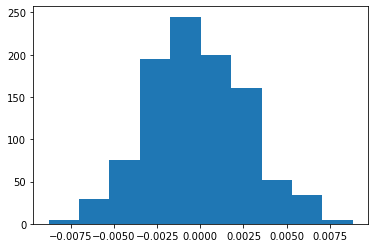

In [40]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(sample_diffs)
plt.show()

In [44]:
## Z-norm observed mean diff
from scipy.stats import norm
norm_mean_diff = (mean_diff - np.mean(sample_diffs)) / np.std(sample_diffs)
print(1-norm.cdf(norm_mean_diff))
print(norm.cdf(-1.96))

0.5026245753681418
0.024997895148220435


###